# Model Definition and Evaluation
## Table of Contents
1. [Libraries](#libraries)
2. [Load dataset](#load-dataset)
3. [Model configuration](#model-configuration)
4. [Implementation](#implementation)
5. [Evaluation](#evaluation)


## 1. Libraries

In [2]:
!pip install openpyxl

In [3]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## 2. Load dataset

Load a preprocessed data and select features.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Load the dataset
# Replace 'your_dataset.csv' with the path to your actual dataset
df = pd.read_csv('/content/drive/MyDrive/opencampus_all_files/rider3/combined_data_r3.csv')

# Feature and target variable selection
Time_real = df['Time']
X = df[['Elevation', 'Slope_prev', 'Slope_next',  'Angle', 'Distance', 'Cumulative_Slope']] # Cumulative slope
y = df['Speed']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


## 3. Model configuration


In [8]:
# Initialize the model
model = Sequential()

# Input Layer (6 features)
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))

# Hidden Layers
model.add(Dense(256, activation='relu'))  # Large hidden layer to capture more complex patterns
model.add(Dropout(0.2))  # Dropout to prevent overfitting
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))  # Dropout again after each hidden layer

# Output Layer
model.add(Dense(1))  # Regression output

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])

# Summarize the model architecture
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,945 (261.50 KB)

 Trainable params: 66,945 (261.50 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# 1. Early Stopping: Stops training when validation loss doesn't improve.
early_stopping = EarlyStopping(
    monitor='val_loss',       # Metric to monitor
    patience=10,              # Number of epochs to wait for improvement
    restore_best_weights=True # Rollback to the best model weights
)

# 2. Model Checkpoint: Saves the best model during training.
model_checkpoint = ModelCheckpoint(
    'nn_best_model.keras',     # Filepath to save the model
    monitor='val_loss',        # Metric to monitor
    save_best_only=True,       # Save only the best model
    mode='min',                # Minimize validation loss
    verbose=1                  # Show a message when saving the model
)

# 3. Learning Rate Scheduler: Reduce learning rate when validation loss plateaus.
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',        # Metric to monitor
    factor=0.1,                # Factor by which to reduce the learning rate
    patience=5,                # Number of epochs to wait before reducing
    min_lr=1e-6,               # Lower bound for learning rate
    verbose=1                  # Show a message when reducing the learning rate
)

# Combine callbacks into a list
callbacks = [early_stopping, model_checkpoint, reduce_lr]

## 4. Implementation



In [10]:
# Normalize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Epoch 1/100
85327/85327 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3667 - mae: 1.5106
Epoch 1: val_loss improved from inf to 3.77023, saving model to nn_best_model.keras
85327/85327 ━━━━━━━━━━━━━━━━━━━━ 132s 2ms/step - loss: 4.3667 - mae: 1.5106 - val_loss: 3.7702 - val_mae: 1.4168 - learning_rate: 0.0010
Epoch 2/100
85293/85327 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8128 - mae: 1.4082
Epoch 2: val_loss improved from 3.77023 to 3.57810, saving model to nn_best_model.keras
85327/85327 ━━━━━━━━━━━━━━━━━━━━ 127s 1ms/step - loss: 3.8128 - mae: 1.4082 - val_loss: 3.5781 - val_mae: 1.3625 - learning_rate: 0.0010
Epoch 3/100
85296/85327 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6911 - mae: 1.3843
Epoch 3: val_loss improved from 3.57810 to 3.49879, saving model to nn_best_model.keras
85327/85327 ━━━━━━━━━━━━━━━━━━━━ 128s 1ms/step - loss: 3.6911 - mae: 1.3843 - val_loss: 3.4988 - val_mae: 1.3542 - learning_rate: 0.0010
Epoch 4/100
85295/85327 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6076

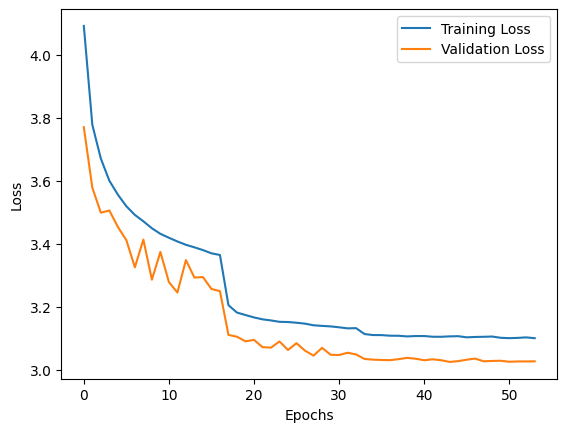

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
# Train the model with callbacks
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    callbacks=callbacks       # Pass callbacks to the fit method
)

# Evaluate the model
loss, mae = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Optionally, plot the training history (e.g., loss or MAE over epochs)
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Download calculated model on local drive
from google.colab import files
file_path = '/content/nn_best_model.keras'  # Full path to the file
files.download(file_path)


## 5. Evaluation

Comparison between linear and neural network model.


#### Load test files

In [14]:
# unzip test files
!unzip /content/drive/MyDrive/opencampus_all_files/rider3/Rider3_test.zip -d /content

Archive:  /content/drive/MyDrive/opencampus_all_files/rider3/Rider3_test.zip
   creating: /content/content/Rider3_test/
  inflating: /content/content/Rider3_test/f234.csv  
  inflating: /content/content/Rider3_test/f114.csv  
  inflating: /content/content/Rider3_test/f559.csv  
  inflating: /content/content/Rider3_test/f47.csv  
  inflating: /content/content/Rider3_test/f566.csv  
  inflating: /content/content/Rider3_test/f144.csv  
  inflating: /content/content/Rider3_test/f24.csv  
  inflating: /content/content/Rider3_test/f647.csv  
  inflating: /content/content/Rider3_test/f437.csv  
  inflating: /content/content/Rider3_test/f537.csv  


#### Evaluation 1 - Linear Regression

In [12]:
# Load linear model
lr_model = joblib.load('/content/drive/MyDrive/opencampus_all_files/models/r3_init_lr_model.joblib')

In [15]:
# Define the folder containing the files
input_folder_path = '/content/content/Rider3_test/'
output_folder_path = '/content/content/Rider3_test_LR/'

# Create output_folder_path
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

# List all CSV files in the folder
csv_files = [f for f in os.listdir(input_folder_path) if f.endswith('.csv')]

# Iterate through each file in the folder
for file in csv_files:
    file_path = os.path.join(input_folder_path, file)

    # Read test file
    df = pd.read_csv(file_path)

    # Feature selection
    real_time = df['Time']
    X = df[['Elevation', 'Slope_prev', 'Slope_next', 'Angle', 'Distance', 'Cumulative_Slope']]
    y = df['Speed']

    # Make predictions on the new data
    y_pred = lr_model.predict(X)

    # Add the predicted values as a new column 'Speed_pred' in the original DataFrame
    df['Speed_pred'] = y_pred

    # Calculate MAE between df['Speed_pred'] and df['Speed']
    mae = mean_absolute_error(df['Speed'], df['Speed_pred'])
    print(f"File: {file} | Mean Absolute Error: {mae}")

    # Initialize Time column
    df['Time_pred'] = float(df['Time'].iloc[0])

    # Compute predicted time
    for i in range(2, len(df)):
        if df.loc[i, 'Speed_pred'] < 0:
            df.loc[i, 'Speed_pred'] = 0
        if pd.notna(df.loc[i, 'Speed_pred']):
            if df.loc[i, 'Speed_pred'] != 0:
                df.loc[i, 'Time_pred'] = (
                    df.loc[i - 1, 'Time_pred'] +
                    (df.loc[i, 'Distance'] - df.loc[i - 1, 'Distance']) / df.loc[i, 'Speed_pred']
                )
            else:
                df.loc[i, 'Time_pred'] = df.loc[i - 1, 'Time_pred']

    # Save the processed DataFrame to a new file (optional)
    output_file_path = os.path.join(output_folder_path, f"lr_{file}")
    df.to_csv(output_file_path, index=False)


File: f437.csv | Mean Absolute Error: 1.668973024420697
File: f537.csv | Mean Absolute Error: 1.7554145840209456
File: f566.csv | Mean Absolute Error: 2.262456970434034
File: f144.csv | Mean Absolute Error: 1.648155153952739
File: f24.csv | Mean Absolute Error: 2.003406576574774
File: f114.csv | Mean Absolute Error: 1.7488265902170683
File: f559.csv | Mean Absolute Error: 2.0890018601949847
File: f234.csv | Mean Absolute Error: 1.7416209288971654
File: f47.csv | Mean Absolute Error: 2.0508174928151908
File: f647.csv | Mean Absolute Error: 2.0359019365014523


#### Evaluation 2 - Neural Network

In [16]:
# Load neural network model
nn_model = tf.keras.models.load_model("/content/drive/MyDrive/opencampus_all_files/models/r3_mse_nn_model.keras")

In [17]:
# Define the folder containing the files
input_folder_path = '/content/content/Rider3_test/'
output_folder_path = '/content/content/Rider3_test_NN/'

# Create output_folder_path
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

# List all CSV files in the folder
csv_files = [f for f in os.listdir(input_folder_path) if f.endswith('.csv')]

# Iterate through each file in the folder
for file in csv_files:
    file_path = os.path.join(input_folder_path, file)

    # Read test file
    df = pd.read_csv(file_path)

    # Feature selection
    real_time = df['Time']
    X = df[['Elevation', 'Slope_prev', 'Slope_next', 'Angle', 'Distance', 'Cumulative_Slope']]
    y = df['Speed']

    # Make predictions on the new data
    X_new_scaled = scaler.transform(X)
    y_pred = nn_model.predict(X_new_scaled)

    # Add the predicted values as a new column 'Speed_pred' in the original DataFrame
    df['Speed_pred'] = y_pred

    # Calculate MAE between df['Speed_pred'] and df['Speed']
    mae = mean_absolute_error(df['Speed'], df['Speed_pred'])
    print(f"File: {file} | Mean Absolute Error: {mae}")

    # Initialize Time column
    df['Time_pred'] = float(df['Time'].iloc[0])

    # Compute predicted time
    for i in range(2, len(df)):
        if df.loc[i, 'Speed_pred'] < 0:
            df.loc[i, 'Speed_pred'] = 0
        if pd.notna(df.loc[i, 'Speed_pred']):
            if df.loc[i, 'Speed_pred'] != 0:
                df.loc[i, 'Time_pred'] = (
                    df.loc[i - 1, 'Time_pred'] +
                    (df.loc[i, 'Distance'] - df.loc[i - 1, 'Distance']) / df.loc[i, 'Speed_pred']
                )
            else:
                df.loc[i, 'Time_pred'] = df.loc[i - 1, 'Time_pred']

    # Save the processed DataFrame to a new file (optional)
    output_file_path = os.path.join(output_folder_path, f"nn_{file}")
    df.to_csv(output_file_path, index=False)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
File: f437.csv | Mean Absolute Error: 1.4185177288381339
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
File: f537.csv | Mean Absolute Error: 1.3679558181952007
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
File: f566.csv | Mean Absolute Error: 1.5116033694708106
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
File: f144.csv | Mean Absolute Error: 1.3004845544151193
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
File: f24.csv | Mean Absolute Error: 1.280538647109091
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
File: f114.csv | Mean Absolute Error: 1.3838351290294801
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
File: f559.csv | Mean Absolute Error: 1.241506570306826
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
File: f234.csv | Mean Absolute Error: 1.3852115782484578
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
File: f47.csv | Mean Absolute Error: 1.7581804723629753
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
File: f647.csv | Mean Absolute Error: 1.4378520738654519


### Evaluation summary

In [18]:
# Summary statistics for processed files
output_folder_path = '/content/content/Rider3_test_LR/'
summary_lr = []
processed_files = [f for f in os.listdir(output_folder_path) if f.endswith('.csv')]

for file in processed_files:
    file_path = os.path.join(output_folder_path, file)
    df = pd.read_csv(file_path)

    # Extract the last value of 'Time' and 'Time_pred'
    last_time = df['Time'].iloc[-1]
    last_time_pred = df['Time_pred'].iloc[-1]

    # Calculate percentage difference
    percentage_diff = ((last_time_pred - last_time) / last_time) * 100 if last_time != 0 else None

    # Append to summary
    summary_lr.append({
        'file': file,
        'last_time': last_time,
        'last_time_pred': last_time_pred,
        'percentage_diff': percentage_diff
    })

In [19]:
# Summary statistics for processed files
output_folder_path = '/content/content/Rider3_test_NN/'
summary_nn = []
processed_files = [f for f in os.listdir(output_folder_path) if f.endswith('.csv')]

for file in processed_files:
    file_path = os.path.join(output_folder_path, file)
    df = pd.read_csv(file_path)

    # Extract the last value of 'Time' and 'Time_pred'
    last_time = df['Time'].iloc[-1]
    last_time_pred = df['Time_pred'].iloc[-1]

    # Calculate percentage difference
    percentage_diff = ((last_time_pred - last_time) / last_time) * 100 if last_time != 0 else None

    # Append to summary
    summary_nn.append({
        'file': file,
        'last_time': last_time,
        'last_time_pred': last_time_pred,
        'percentage_diff': percentage_diff
    })

In [20]:
# Print summary
summary_lr_df = pd.DataFrame(summary_lr).sort_values(by=['file'])
print(summary_lr_df)
print(f"Absolute percentage difference in LR model: {summary_lr_df['percentage_diff'].abs().mean()}\n")

summary_nn_df = pd.DataFrame(summary_nn).sort_values(by=['file'])
print(summary_nn_df)
print(f"Absolute percentage difference in NN model: {summary_nn_df['percentage_diff'].abs().mean()}")

          file  last_time  last_time_pred  percentage_diff
8  lr_f114.csv       5553     5600.173762         0.849518
7  lr_f144.csv       6864     6336.960079        -7.678321
4  lr_f234.csv       4294     3540.409084       -17.549858
5   lr_f24.csv       8877     9524.708456         7.296479
0  lr_f437.csv       1138      766.798228       -32.618785
1   lr_f47.csv       5492     5804.706142         5.693848
6  lr_f537.csv       4311     4608.122235         6.892188
9  lr_f559.csv       1412      980.967598       -30.526374
2  lr_f566.csv       2290     1332.727136       -41.802308
3  lr_f647.csv       5229     5369.212654         2.681443
Absolute percentage difference in LR model: 15.358912331780052

          file  last_time  last_time_pred  percentage_diff
6  nn_f114.csv       5553     5542.771289        -0.184202
0  nn_f144.csv       6864     6394.234106        -6.843909
8  nn_f234.csv       4294     3698.357485       -13.871507
1   nn_f24.csv       8877     8618.184727        -2